In [87]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, leastsq
import scipy.constants as ct
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [88]:
# Define constants
ISAT = 1e-9 # Saturation current
N = 1.7
T1 = 350
Q = ct.physical_constants['atomic unit of charge'][0]
KB = ct.physical_constants['Boltzmann constant'][0]
inital_voltages = np.arange(0.1, 2.5, 0.1)
R1 = 1.1e4

In [89]:
step_size = (2.5 - 0.1) / 0.1
V = [1 for i in range(int(step_size + 1))]

In [90]:
def current(Vd, Is, n, T):
    return Is * (np.exp((Vd * Q) / (n * KB * T)) - 1)

def error_func(Vd, Vs, Is, n, R, T):
    return (Vd / R) - (Vs / R) + current(Vd, Is, n, T)

In [91]:
diode_voltage = fsolve(
                error_func,
                V,
                args=(inital_voltages, ISAT, N, R1, T1)
            )
diode_current = current(diode_voltage, ISAT, N, T1)

In [92]:
diode_voltage

array([0.09993376, 0.19947277, 0.29644374, 0.3813319 , 0.4406315 ,
       0.4776876 , 0.50230459, 0.52012676, 0.53389711, 0.54503839,
       0.55435716, 0.56234689, 0.56932861, 0.57552165, 0.58108195,
       0.58612404, 0.59073435, 0.59497963, 0.59891245, 0.60257491,
       0.6060012 , 0.60921952, 0.61225331, 0.61512231])

In [93]:
diode_current

array([6.02199411e-09, 4.79302369e-08, 3.23296545e-07, 1.69710024e-06,
       5.39713543e-06, 1.11193093e-05, 1.79723102e-05, 2.54430214e-05,
       3.32820811e-05, 4.13601465e-05, 4.96038950e-05, 5.79684647e-05,
       6.64246721e-05, 7.49525773e-05, 8.35380046e-05, 9.21705422e-05,
       1.00842332e-04, 1.09547306e-04, 1.18280686e-04, 1.27038645e-04,
       1.35818072e-04, 1.44616407e-04, 1.53431519e-04, 1.62261609e-04])

In [94]:
plot_diode_current = np.log(diode_current)
plot_diode_current

array([-18.92784739, -16.85351928, -14.94469584, -13.28658951,
       -12.12964222, -11.40682739, -10.9266783 , -10.57906906,
       -10.31049141, -10.09319278,  -9.9114412 ,  -9.75561141,
        -9.619442  ,  -9.49865495,  -9.39020888,  -9.29186998,
        -9.20195233,  -9.11915408,  -9.04245006,  -8.97101923,
        -8.90419427,  -8.84142579,  -8.78225622,  -8.72630066])

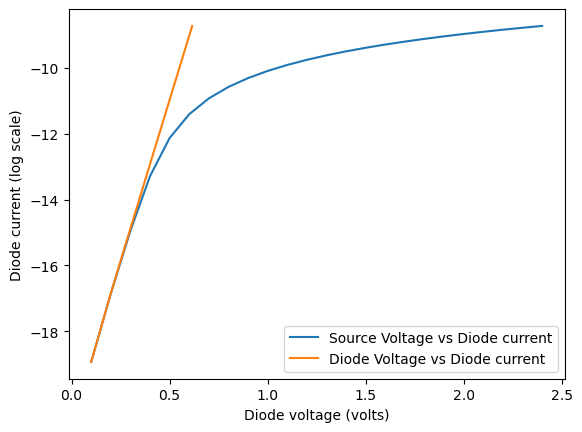

In [95]:
plt.plot(inital_voltages, plot_diode_current, label="Source Voltage vs Diode current")
plt.plot(diode_voltage, plot_diode_current, label="Diode Voltage vs Diode current")
plt.ylabel("Diode current (log scale)")
plt.xlabel("Diode voltage (volts)")
plt.legend()
plt.show()

In [96]:
# Read the contents of diode.txt file
data = pd.read_csv('DiodeIV.txt', header=None, sep=' ')
source_voltages = []
measured_current = []
for V_s, I_d in data.values:
    source_voltages.append(V_s)
    measured_current.append(I_d)
    
source_voltages = np.asarray(source_voltages)
measured_current = np.asarray(measured_current)

In [97]:
AREA = 1e-8
TEMP2 = 375
R2 = 1e4
PHI = 0.8
IDEALITY = 1.5

# Functions
def compute_diode_current(Is, Vs, R, n, I):
    Vt = IDEALITY * KB * TEMP2 / Q
    result = Is * (np.exp(((Vs - I * R) * Q) / (n * KB * TEMP2)) - 1)
    return result

def Isat(phi):
    return AREA * TEMP2**2 * np.exp(-phi * Q / (KB * TEMP2))

# Define the residual functions
def residual_phi(phi, n, R):
    Is_temp = Isat(phi)
    return np.absolute(measured_current - compute_diode_current(Is_temp, source_voltages, R, n, measured_current))

def residual_n(n, phi, R):
    Is_temp = Isat(phi)
    return np.absolute(measured_current - compute_diode_current(Is_temp, source_voltages, R, n, measured_current))

def residual_R(R, n, phi):
    Is_temp = Isat(phi)
    return np.absolute(measured_current - compute_diode_current(Is_temp, source_voltages, R, n, measured_current))

In [98]:
# Set the thresholds
THRESHOLD = 1e-6
avg_val = 10
MAX_ITER = 1e6
iter_count = 0

# Initialization
R = [R2]  # Initial guess for resistor R
phi = [PHI]  # Initial guess for phi
n = [IDEALITY]  # Initial guess for ideality factor n

res_avg = THRESHOLD + 1  # Initialize res_avg to a value greater than RES_ERR_THRESH
count = 1  # Initialize iteration count

# Iterative optimization loop
while res_avg > THRESHOLD and count < MAX_ITER:
    # Perform the least squares optimization to get the values of R, phi, and n
    R = leastsq(residual_R, R[0], args=(n[0], phi[0]))[0]
    phi = leastsq(residual_phi, phi[0], args=(n[0], R))[0]
    n = leastsq(residual_n, n[0], args=(phi[0], R))[0]

    # Calculate the average residual error
    res_avg = np.average(np.absolute(residual_phi(phi[0], n[0], R)))

    # Print iteration progress
    if count % 10000 == 0:
        print(f"Iter#: {count} ; phi: {phi[0]:.4f} ; n: {n[0]:.4f} ; R: {R[0]:.2f} ; Residual: {res_avg:.3e}")

    # Increment the iteration count
    count += 1

Iter#: 100000 ; phi: 0.8076 ; n: 1.1823 ; R: 1148.28 ; Residual: 1.227e-05
Iter#: 200000 ; phi: 0.8599 ; n: 1.1085 ; R: 1149.41 ; Residual: 4.408e-06
Iter#: 300000 ; phi: 0.8787 ; n: 1.0841 ; R: 1149.78 ; Residual: 1.648e-06


In [99]:
print("\n\n==========\n")
print(f"Took {count} iterations to complete...")
print(f"ESTIMATED RESISTANCE (R) : {R[0]}")
print(f"ESTIMATED Phi : {phi[0]}")
print(f"ESTIMATED Ideality factor (n) : {n[0]}")




Took 351404 iterations to complete...
ESTIMATED RESISTANCE (R) : 1149.8694366765235
ESTIMATED Phi : 0.8831124444752319
ESTIMATED Ideality factor (n) : 1.0785529552286055


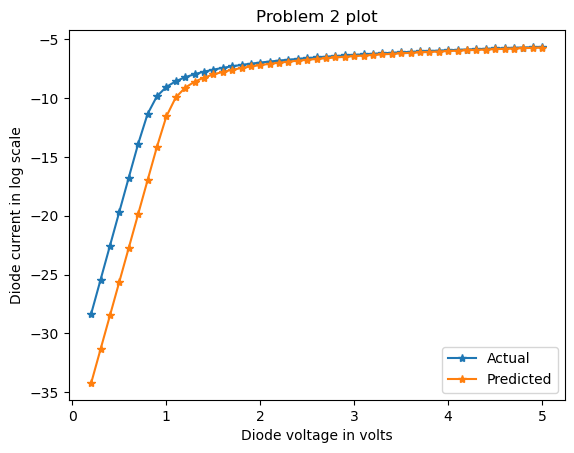

In [100]:
# Init the diode voltage for prediction
Vd_init = [1 for i in range(len(source_voltages))]

# Calculate the saturation current, diode voltage, diode current based upon the predicted values of phi
predicted_Is = Isat(n[0])
diode_voltage_pred = fsolve(error_func, Vd_init, args=(source_voltages, predicted_Is, n[0], R[0], TEMP2))
diode_current_pred = current(diode_voltage_pred, predicted_Is, n[0], TEMP2)

# Set axes params for the plot
plt.xlabel("Diode voltage in volts")
plt.ylabel("Diode current in log scale")
plt.title("Problem 2 plot")

# Plot the given values of Source voltage and diode current in DiodeIV.txt (Actual values)
plt.plot(source_voltages[1:], np.log(measured_current[1:]), label="Actual", marker='*')

# Plot the given values of diode current and diode voltage in DiodeIV.txt (Predicted values)
plt.plot(source_voltages[1:], np.log(diode_current_pred[1:]), label="Predicted", marker='*')
plt.legend()
plt.show()